<a href="https://colab.research.google.com/github/ukyanjo/dacon-sangchu/blob/overfitting-lstm-3rd/sangchu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Bidirectional

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## Fixed RandomSeed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(20) # Seed 고정

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/sangchu

/content/drive/MyDrive/Colab Notebooks/sangchu


In [5]:
PROJECT_DIR = os.getcwd()
PROJECT_DIR

'/content/drive/MyDrive/Colab Notebooks/sangchu'

In [6]:
DATA_DIR = os.path.join(PROJECT_DIR, 'sangchu-data')
DATA_DIR

'/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data'

## Data Pre-processing

In [7]:
all_input_list = sorted(glob.glob(os.path.join(DATA_DIR, 'train_input', '*.csv')))
all_target_list = sorted(glob.glob(os.path.join(DATA_DIR, 'train_target', '*.csv')))
all_input_list

['/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_01.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_02.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_03.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_04.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_05.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_06.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_07.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_08.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_09.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_10.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/train_input/CASE_11.csv',
 '/content/drive/MyDrive/Colab N

In [8]:
pd.read_csv(all_input_list[0])

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,30.880000,82.255000,464.433333,0.000000,252.0,3638.54,18255.19,254644.43,976.332,13619.004,0,0,19231.522,268263.434
668,27,20:00,29.068333,82.506667,534.633333,0.000000,126.0,3764.54,618.82,255263.25,33.096,13652.100,0,0,651.916,268915.350
669,27,21:00,28.246667,82.835000,563.433333,0.000000,0.0,3764.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350
670,27,22:00,28.005000,82.850000,577.150000,0.000000,126.0,3890.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350


In [9]:
input_df_list = []
for i in range(0, 28):
    input_df = pd.read_csv(all_input_list[i])
    input_df = input_df[[col for col in input_df.columns if not '누적' in col]]
    input_df['obs_time'] = [ num for num in range(0, 24) ] * 28
    input_df.drop(columns=['시간당총광량'], inplace=True)
    input_df['case'] = i + 1
    input_df_list.append(input_df)

# input_df_list
input_df_total = pd.concat(input_df_list, axis=0)

In [10]:
input_df_total.loc[input_df_total['시간당분무량'] < 0, '시간당분무량' ] = (-1) * input_df_total.loc[input_df_total['시간당분무량'] < 0, '시간당분무량' ]

In [11]:
input_df_total.loc[input_df_total['시간당백색광량'] < 0,  '시간당백색광량'] = np.nan
input_df_total.loc[input_df_total['시간당적색광량'] < 0,  '시간당적색광량'] = np.nan
input_df_total.loc[input_df_total['시간당청색광량'] < 0,  '시간당청색광량'] = np.nan

In [12]:
input_df_total['시간당백색광량'] = input_df_total['시간당백색광량'].interpolate()
input_df_total['시간당적색광량'] = input_df_total['시간당적색광량'].interpolate()
input_df_total['시간당청색광량'] = input_df_total['시간당청색광량'].interpolate()
# input_df_total.columns = ['DAT', 'obs_time', 'internal_temp', 'internal_humid', 'co2', 'ec', 'sprinkle', 'whiteperhour', 'redperhour', 'blueperhour', 'case']
input_df_total

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,28
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,28
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,28
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,28


In [13]:
input_df_total.loc[(input_df_total["DAT"]==25)&(input_df_total["case"]==15),:]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
600,25,0,26.071667,77.768333,382.750000,1.297974,0.00,0.0,5758.704,3634.28,15
601,25,1,25.998333,76.401667,369.683333,1.299823,769.00,0.0,5857.992,3696.94,15
602,25,2,25.995000,77.925000,368.066667,1.305844,303.44,0.0,5857.992,3696.94,15
603,25,3,25.850000,76.886667,367.900000,1.307893,769.00,0.0,5857.992,3696.94,15
604,25,4,25.830000,77.106667,367.683333,1.312816,286.75,0.0,5857.992,3696.94,15
605,25,5,25.593333,78.850000,384.566667,1.314302,769.00,0.0,5857.992,3696.94,15
606,25,6,25.688333,76.723333,375.766667,1.318513,254.60,0.0,5857.992,3696.94,15
607,25,7,25.846667,77.168333,370.666667,1.319562,769.00,0.0,5758.704,3634.28,15
608,25,8,25.946667,78.521667,394.100000,1.315839,1139.34,0.0,5857.992,3696.94,15
609,25,9,25.861667,76.481667,380.783333,1.313203,1297.49,0.0,5857.992,3696.94,15


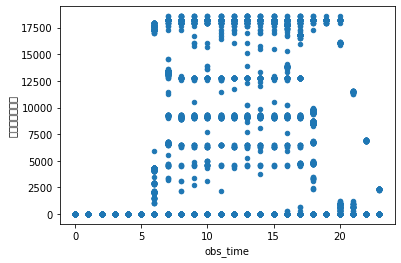

In [14]:
input_df_total.plot(kind="scatter", x="obs_time", y='시간당백색광량')

In [20]:
input_df_total[input_df_total['case']==1]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.000,0.0,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.00,0.000,0.0,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.00,0.000,0.0,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.00,0.000,0.0,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.00,0.000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,30.880000,82.255000,464.433333,0.000000,252.0,18255.19,976.332,0.0,1
668,27,20,29.068333,82.506667,534.633333,0.000000,126.0,618.82,33.096,0.0,1
669,27,21,28.246667,82.835000,563.433333,0.000000,0.0,0.00,0.000,0.0,1
670,27,22,28.005000,82.850000,577.150000,0.000000,126.0,0.00,0.000,0.0,1


In [48]:
input_df_total[(input_df_total['DAT']==24)&(input_df_total['case']==2)]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
576,24,0,25.120000,80.126666,621.700000,0.0,61.7,0.0,0.0000,0.0000,2
577,24,1,24.940000,80.056666,624.466667,0.0,61.7,0.0,0.0000,0.0000,2
578,24,2,24.801666,80.288334,628.700000,0.0,61.7,0.0,0.0000,0.0000,2
579,24,3,24.833333,80.405001,629.366667,0.0,61.7,0.0,0.0000,0.0000,2
580,24,4,24.805000,80.405001,628.683333,0.0,61.7,0.0,0.0000,0.0000,2
581,24,5,24.568333,80.538333,633.166667,0.0,61.7,0.0,0.0000,0.0000,2
582,24,6,24.476667,80.985000,614.633333,0.0,123.4,0.0,1110.3708,1051.1215,2
583,24,7,24.346666,79.966667,548.716667,0.0,123.4,0.0,3547.8912,3358.5760,2
584,24,8,24.875000,80.308001,520.650000,0.0,123.4,0.0,4880.0052,4619.6085,2
585,24,9,25.601667,71.981945,503.033333,0.0,123.4,0.0,4881.6600,4621.1750,2


In [50]:
input_df_total[input_df_total['ec관측치']==0]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
646,26,22,27.128334,82.660000,847.650000,0.0,0.00,0.00,0.0,0.0,1
647,26,23,27.090000,81.966667,810.533333,0.0,126.00,0.00,0.0,0.0,1
648,27,0,27.018333,82.780000,778.100000,0.0,0.00,0.00,0.0,0.0,1
649,27,1,26.965000,82.443333,746.366667,0.0,119.57,0.00,0.0,0.0,1
650,27,2,26.928333,82.845000,718.533333,0.0,0.00,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
545,22,17,28.995000,58.980000,422.633333,0.0,2085.22,8972.89,0.0,0.0,23
552,23,0,28.705000,60.586667,488.433333,0.0,1874.40,0.00,0.0,0.0,23
554,23,2,29.111667,60.476667,470.866667,0.0,1871.80,0.00,0.0,0.0,23
555,23,3,29.100000,60.406666,463.616667,0.0,1752.23,0.00,0.0,0.0,23


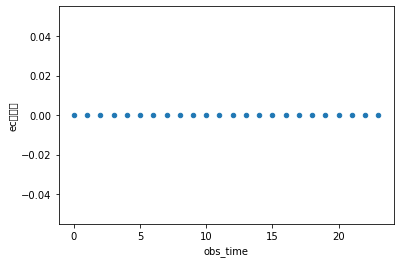

In [47]:
input_df_total[(input_df_total['DAT']==24)&(input_df_total['case']==2)].plot(kind="scatter", x="obs_time", y='ec관측치')

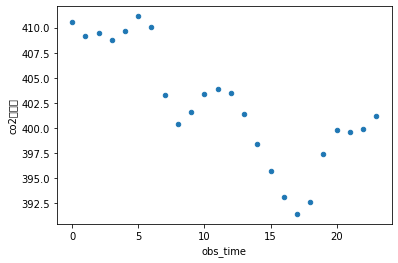

In [75]:
input_df_total[(input_df_total['DAT']==19)&(input_df_total['case']==3)].plot(kind="scatter", x="obs_time", y='co2관측치')

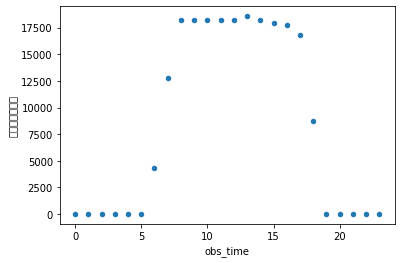

In [74]:
input_df_total[(input_df_total['DAT']==19)&(input_df_total['case']==3)].plot(kind="scatter", x="obs_time", y='시간당백색광량')

In [76]:
original_df = input_df_total.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
input_df_total.iloc[:, :-1] = scaler.fit_transform(input_df_total.iloc[:, :-1].copy())
original_df.describe()

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,case
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,11.500000,26.027719,63.935090,498.860695,1.507566,523.754489,6323.873473,1572.430914,1243.069492,14.500000
std,8.077962,6.922371,3.948988,11.657905,120.421248,1.042010,544.201487,8120.283264,2936.281308,2470.253289,8.077962
min,0.000000,0.000000,0.000000,0.000000,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.750000,5.750000,23.971250,57.494583,420.245833,0.929581,0.000000,0.000000,0.000000,0.000000,7.750000
50%,13.500000,11.500000,26.291667,62.118333,473.983333,1.308517,252.000000,0.000000,0.000000,0.000000,14.500000
75%,20.250000,17.250000,28.106667,73.157166,551.105952,2.291322,769.000000,18236.625400,1495.939200,1306.461000,21.250000
max,27.000000,23.000000,42.643334,93.350002,1714.850000,5.462324,3144.130000,18564.600000,9928.800000,9399.000000,28.000000


In [77]:
new_input_list = []
for case in range(1, 29):
    new_input_list.append(input_df_total.loc[input_df_total['case']==case, :'시간당청색광량'])
    
new_input_list[0]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
0,0.0,0.000000,0.593293,0.876647,0.287477,0.257663,0.000000,0.000000,0.000000,0.0
1,0.0,0.043478,0.602213,0.870533,0.283053,0.257949,0.040075,0.000000,0.000000,0.0
2,0.0,0.086957,0.592668,0.872755,0.285553,0.257567,0.000000,0.000000,0.000000,0.0
3,0.0,0.130435,0.594583,0.871969,0.293250,0.257526,0.040075,0.000000,0.000000,0.0
4,0.0,0.173913,0.595443,0.872880,0.301117,0.258328,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
667,1.0,0.826087,0.724146,0.881146,0.244210,0.000000,0.080149,0.983333,0.098333,0.0
668,1.0,0.869565,0.681662,0.883842,0.286641,0.000000,0.040075,0.033333,0.003333,0.0
669,1.0,0.913043,0.662393,0.887359,0.304049,0.000000,0.000000,0.000000,0.000000,0.0
670,1.0,0.956522,0.656726,0.887520,0.312339,0.000000,0.040075,0.000000,0.000000,0.0


In [78]:
new_target_list = []
for i in range(0, 28):
    target_df = pd.read_csv(all_target_list[i])
    target_df['diff'] = target_df['predicted_weight_g'].diff()
    target_df.loc[0, 'diff'] = target_df.loc[0, 'predicted_weight_g']
    # target_df.drop(columns=['predicted_weight_g'], inplace=True)
    # target_df.rename(columns={'diff':'predicted_weight_g'}, inplace=True)
    new_target_list.append(target_df)

In [105]:
data_list = []
label_list = []

for input_df, target_df in tqdm(zip(new_input_list, new_target_list)):
    
    input_length = int(len(input_df)/6)
    target_length = int(len(target_df))
    
    for idx in range(target_length):
        time_series = input_df[(24*idx)+6:(24*idx)+18].values
        data_list.append(time_series)
    for label in target_df["diff"]:
        label_list.append(label)

x_data = np.array(data_list)
y_data = np.array(label_list)

x_data.shape, y_data.shape

0it [00:00, ?it/s]

((784, 12, 10), (784,))

In [106]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.15, shuffle=True)
x_train.shape

(666, 12, 10)

In [107]:
input_shape = (x_train[0].shape[0], x_train[0].shape[1])

# model = Sequential()
# model.add(Conv1D(32, 6, input_shape=input_shape))
# model.add(Bidirectional(LSTM(32, return_sequences=True)))
# model.add(Bidirectional(LSTM(16)))
# model.add(Dense(1, activation = 'relu'))
# optimizer = tf.optimizers.Adam(0.001)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = Sequential()
model.add(Conv1D(32, 6, input_shape=input_shape))
model.add(LSTM(32, dropout=0.2, return_sequences=False, input_shape=input_shape))
model.add(Dense(1, activation='relu'))
optimizer = tf.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, 
          validation_data=(x_valid, y_valid),
          epochs=100, 
          batch_size=8,
        #   callbacks=[es],
         )

Epoch 1/100
84/84 [==============================] - 21s 10ms/step - loss: 13.8185 - val_loss: 13.3062
Epoch 2/100
84/84 [==============================] - 0s 5ms/step - loss: 8.6384 - val_loss: 10.5974
Epoch 3/100
84/84 [==============================] - 1s 6ms/step - loss: 7.8543 - val_loss: 9.7867
Epoch 4/100
84/84 [==============================] - 1s 9ms/step - loss: 7.5793 - val_loss: 11.4026
Epoch 5/100
84/84 [==============================] - 0s 5ms/step - loss: 7.7397 - val_loss: 9.6158
Epoch 6/100
84/84 [==============================] - 0s 5ms/step - loss: 7.4692 - val_loss: 9.2098
Epoch 7/100
84/84 [==============================] - 0s 5ms/step - loss: 7.4156 - val_loss: 9.3663
Epoch 8/100
84/84 [==============================] - 1s 6ms/step - loss: 7.9579 - val_loss: 9.3676
Epoch 9/100
84/84 [==============================] - 1s 7ms/step - loss: 7.3713 - val_loss: 9.8362
Epoch 10/100
84/84 [==============================] - 1s 8ms/step - loss: 7.4530 - val_loss: 9.2820
Epo

## Inference

In [108]:
test_input_list = sorted(glob.glob(os.path.join(DATA_DIR, 'test_input', '*.csv')))
test_target_list = sorted(glob.glob(os.path.join(DATA_DIR, 'test_target', '*.csv')))
test_target_list

['/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target/TEST_01.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target/TEST_02.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target/TEST_03.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target/TEST_04.csv',
 '/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target/TEST_05.csv']

In [109]:
for test_input_path, test_target_path in zip(test_input_list, test_target_list):
    input_df = pd.read_csv(test_input_path)
    input_df = input_df[[col for col in input_df.columns if not '누적' in col]]
    input_df['obs_time'] = [ num for num in range(0, 24) ] * 28
    input_df.drop(columns=['시간당총광량'], inplace=True)

    input_df.loc[input_df['시간당분무량'] < 0, '시간당분무량' ] = (-1) * input_df.loc[input_df['시간당분무량'] < 0, '시간당분무량' ]
    input_df.loc[input_df['시간당백색광량'] < 0,  '시간당백색광량'] = np.nan
    input_df.loc[input_df['시간당적색광량'] < 0,  '시간당적색광량'] = np.nan
    input_df.loc[input_df['시간당청색광량'] < 0,  '시간당청색광량'] = np.nan
    input_df['시간당백색광량'] = input_df['시간당백색광량'].interpolate()
    input_df['시간당적색광량'] = input_df['시간당적색광량'].interpolate()
    input_df['시간당청색광량'] = input_df['시간당청색광량'].interpolate()

    input_df.iloc[:, :] = scaler.transform(input_df.iloc[:, :].copy())   

    input_length = int(len(input_df)/6)
    
    data_list = []
    for idx in range(28):
        time_series = input_df[(24*idx)+6:(24*idx)+18].values
        data_list.append(time_series)
        
    pred = model.predict(np.array(data_list)).tolist()  

    submit_df = pd.read_csv(test_target_path)
    print(submit_df.shape)
    submit_df['predicted_weight_g'] = np.ravel(pred)
    submit_df['predicted_weight_g'] = submit_df['predicted_weight_g'].cumsum()
    submit_df.to_csv(test_target_path, index=False)


1/1 [==============================] - 1s 585ms/step
(28, 2)
1/1 [==============================] - 0s 17ms/step
(28, 2)
1/1 [==============================] - 0s 16ms/step
(28, 2)
1/1 [==============================] - 0s 15ms/step
(28, 2)
1/1 [==============================] - 0s 17ms/step
(28, 2)


## Submission

In [110]:
import zipfile
# os.chdir("./sangchu-data/test_target/")
print(os.getcwd())
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    print(path)
    submission.write(path)
submission.close()

/content/drive/MyDrive/Colab Notebooks/sangchu/sangchu-data/test_target
TEST_01.csv
TEST_02.csv
TEST_03.csv
TEST_04.csv
TEST_05.csv
